In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset
# https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

# Dataset and DataLoader Reference
# https://www.kaggle.com/code/shreydan/monocular-depth-estimation-nyuv2

Mounted at /content/drive


# Read

In [2]:
import os
from pathlib import Path

In [3]:
os.chdir('/content/drive/MyDrive/Depth Estimation')

In [4]:
import pandas as pd

base_path = Path("/content/drive/MyDrive/Depth Estimation/")
train_csv = base_path / Path("data/nyu2_train.csv")

df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: base_path / x)
df[1] = df[1].map(lambda x: base_path / x)

In [5]:
test_csv = base_path / Path("data/nyu2_test.csv")
test_df = pd.read_csv(test_csv, header=None)
test_df[0] = test_df[0].map(lambda x: base_path / x)
test_df[1] = test_df[1].map(lambda x: base_path / x)

In [6]:
df.head()

,0,1
0,/content/drive/MyDrive/Depth Estimation/data/n...,/content/drive/MyDrive/Depth Estimation/data/n...
1,/content/drive/MyDrive/Depth Estimation/data/n...,/content/drive/MyDrive/Depth Estimation/data/n...
2,/content/drive/MyDrive/Depth Estimation/data/n...,/content/drive/MyDrive/Depth Estimation/data/n...
3,/content/drive/MyDrive/Depth Estimation/data/n...,/content/drive/MyDrive/Depth Estimation/data/n...
4,/content/drive/MyDrive/Depth Estimation/data/n...,/content/drive/MyDrive/Depth Estimation/data/n...


In [7]:
len(df)

50688

In [11]:
def check_data(df):
    flag = False

    for idx in range(len(df)):
        image_path = df.iloc[idx, 0]
        mask_path = df.iloc[idx, 1]

        if not os.path.exists(image_path):
            print(f"Image path does not exist: {image_path}")
            flag = True

        if not os.path.exists(mask_path):
            print(f"Mask path does not exist: {mask_path}")
            flag = True

    return flag

In [12]:
# All file exist if flag is false
flag = check_data(df)
print("Error" if flag else "No Error")

No Error


# Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df,test_size=0.1,shuffle=False)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=False)

train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

# Visualize

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None: d_min = np.min(depth)
    if d_max is None: d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

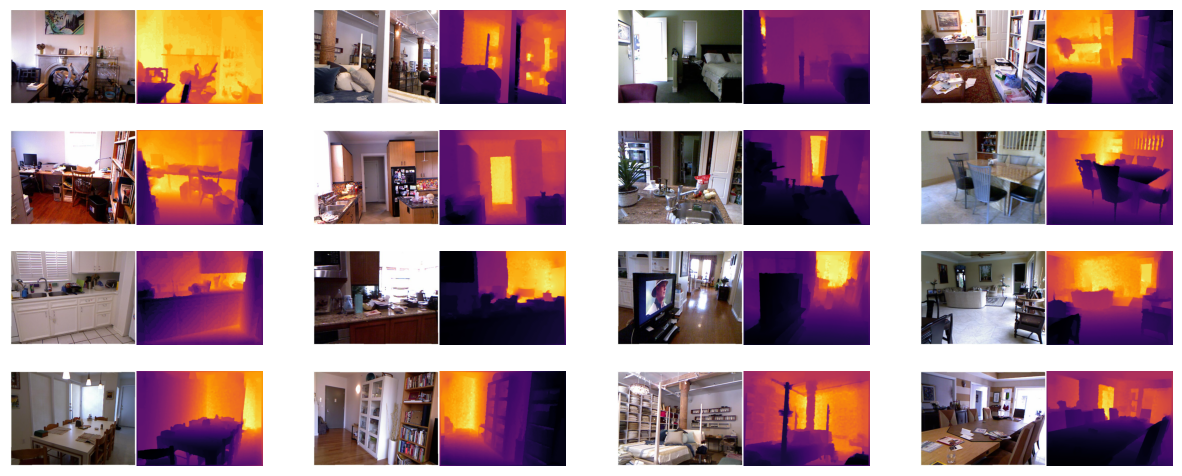

In [15]:
plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(image,mask)
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Augmentation

In [16]:
import albumentations as A

sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]

train_tfms = A.Compose([
    *sample_tfms
])

valid_tfms = A.Compose([

])

test_tfms = A.Compose([

])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Dataset

In [17]:
import cv2 as cv

class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp

In [18]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

# Transforms Visualization

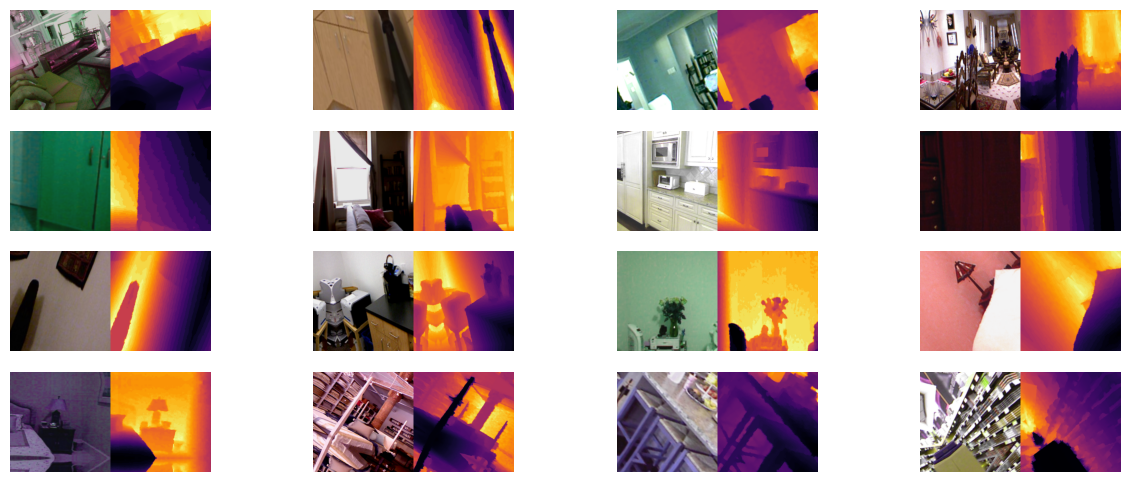

In [20]:
plt.figure(figsize=(15, 6))
randoms = [train_ds[idx] for idx in np.random.randint(0,len(train_ds),(16,))]

for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Data Loader

In [21]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,shuffle=True,batch_size=4)
val_dl = DataLoader(val_ds,shuffle=False,batch_size=4)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=1)
len(train_dl), len(val_dl), len(test_dl)

(11405, 1141, 507)

In [23]:
for batch in train_dl:
    imgs, masks = batch
    print(f"Input shape: {imgs.shape}, Target shape: {masks.shape}")
    break

Input shape: torch.Size([4, 384, 384, 3]), Target shape: torch.Size([4, 384, 384])
